In [1]:
from Bio import SeqIO
from Bio import AlignIO
from Bio.SeqRecord import SeqRecord
import Bio.Align
from Bio.Align.AlignInfo import SummaryInfo
from Bio.Seq import Seq
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import scipy as sp

In [2]:
#complete these variables with the input files directory 
dog_breeds = r"C:\Users\lena1\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\data\dog_breeds.fa"
mystery_breed = r"C:\Users\lena1\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\data\mystery.fa"
output = r"C:\Users\lena1\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\results"
ind_breeds = r"C:\Users\lena1\OneDrive - Birkbeck, University of London\UNI\Biocomputing\Coursework\individual_breed_sequences"

In [3]:
class Breed():
    """class to store information about every breed and their sequence"""
    all_instances = []
    def __init__(self, sequence, breed, fasta):
        self.sequence = sequence
        self.breed = breed
        self.fasta = fasta
        Breed.all_instances.append(self)  #stores all initialised sequences


In [4]:
#open the fasta file and save the sequence breed and sequence name in a Breed Class to ba sccessed at a later point 
all_breeds = set()
for record in SeqIO.parse(dog_breeds, "fasta"):
    for key in list(record.description.split("[")):  #get the description of each sequence 
        if "breed" in key and "isolate" not in key: #get breed name 
            record.name = Breed(record.seq, key[6:-2], record)
            #get a list of all the Breeds in the database
            all_breeds.add(key[6:-2])

In [5]:

#write a fasta file containing all sequences that belong to the same breed 
os.chdir(ind_breeds) # set up directory where files will be created
for breed in all_breeds: # creates a temporary variable corresponding to each individual dog breed 
    temp = breed
    file = open(breed, "w") #creates a filename eith the name of the breed in a wwritable format
    for key in Breed.all_instances: 
        if key.breed == temp: #itterates through all of the class instances and checks if the breedd is the same as the breed in all_breeds
            SeqIO.write(key.fasta, file, "fasta") #adds the sequence to the file 
    file.close() #once all the sequences are added file is closed


In [6]:
#create a consensus sequence for each breed 

consensus_sequences = [] #store the concensus sequences in a fasta format 
os.chdir(ind_breeds) #set directory to where the sequences are 
for file in all_breeds:
    alignments = AlignIO.parse(file, "fasta") #align all the sequences in each file
    recordname = f"{file}_consensus" #create a record name  
    #create a consensus file for all alignements
    for alignment in alignments: 
        summary = SummaryInfo(alignment) #get summary info of each alignment to create a concensus 
        consensus = summary.dumb_consensus() #create a concensus of each alignmernt 
        # Create a SeqRecord with an ID (you can customize this)
        seq_record = SeqRecord(Seq(consensus), id=recordname) #create a fasta format sequence using the consensus sequence and recordname
        consensus_sequences.append(seq_record)#add each concensus seq to a list 

C:\Users\lena1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\Bio\Align\AlignInfo.py:63: BiopythonDeprecationWarning: The `dumb_consensus` method is deprecated and will be removed in a future release of Biopython. As an alternative, you can convert the multiple sequence alignment object to a new-style Alignment object by via its `.alignment` property, and then create a Motif object. You can then use the `.consensus` or `.degenerate_consensus` property of the Motif object to get a consensus sequence. For more control over how the consensus sequence is calculated, you can call the `calculate_consensus` method on the `.counts` property of the Motif object. This is an example for a multiple sequence alignment `msa` of DNA nucleotides:
>>> from Bio.Seq import Seq
>>> from Bio.SeqRecord import SeqRecord
>>> from Bio.Align import MultipleSeqAlignment
>>> from Bio.Align.AlignInfo import SummaryInfo
>>> msa = MultipleS

In [7]:
#create an alignemnt between each consensus sequence and the unknown sequence
def Best_aligment(mystery_sequence = mystery_breed, breed_seqs =consensus_sequences): 
    """Creates an alignment between input sequence and sequences in database and returns the name of the alignment with the best score"""
    max = float()
    max_breed = []
    for record in SeqIO.parse(mystery_sequence, "fasta"): #get sequence from file 
        unknown_sequence = record.seq
    # Create a pairwise alignment
    aligner = Bio.Align.PairwiseAligner() 
    for record in breed_seqs: 
        alignment_score = aligner.score(record.seq, unknown_sequence) #get the alinment score of each comparasion 
        alignemnt = aligner.align(record.seq, unknown_sequence) #get the alignment
        if alignment_score > max: #find out what the maximum score is 
            max = alignment_score
            max_breed = (record.id).replace("_consensus", ""), record.seq, alignemnt[0],alignment_score #find out what breed and sequence is asociated withe the maximum score 
    return max_breed

Best_aligned = Best_aligment() # store the results for ease of accesss

In [8]:
#get top 3 alignments
def top3_alignments(mystery_sequence = mystery_breed, breed_seqs =consensus_sequences): 
    """Takes in an unknown sequence and compares it to the database to return the top 3 alignments"""
    all_scores = []
    top_3 = [] #get the score of the top 5 alignments
    for record in SeqIO.parse(mystery_sequence, "fasta"): #get sequence from file 
        unknown_sequence = record.seq
    # Create a pairwise alignment
    aligner = Bio.Align.PairwiseAligner() 
    for record in breed_seqs: 
        alignment = aligner.score(record.seq, unknown_sequence) #get the alinment score of each comparasion 
        all_scores.append(alignment)
    all_scores.sort(reverse=True) # sort the alignment scores from highest to lowest     
    for key in range(3):
        for record in breed_seqs:
            if aligner.score(record.seq, unknown_sequence) == all_scores[key]:
                top_3.append(aligner.align(record.seq, unknown_sequence))
    return top_3


In [9]:
def percentage_similarity(aln):
    """Calculates the percentage similarity between input sequence and top 3 sequence alignments"""
    identical_columns = float()
    for a in range(len(aln[0])): #itterate through every column of the alignment
        if aln[0,a] == aln[1,a]: #check if first and second sequence at column a is the same 
            identical_columns += 1 #if sequences the same add 1 to the amount of identical columns 
    percentage = 100 * identical_columns / float(len(aln[0])) #calculate the percentage 
    return  round(percentage,3) #return percentage to 3dp

top_percentages = []
for alignment in top3_alignments():
    top_percentages.append(percentage_similarity((alignment[0])))

In [10]:
#get results aka the breed, its sequence and percentage similarity 
print("The breed most similar to the mustery DNA file is the", Best_aligned[0], "its percent identity is", top_percentages[0], "% and the breeds consensus sequence is:", Best_aligned[1] )
print("the alignment of the mystery dog breed and", Best_aligned[0], "is displayed here\n", Best_aligned[2])

The breed most similar to the mustery DNA file is the English Springer Spaniel its percent identity is 99.678 % and the breeds consensus sequence is: GTTAATGTAGCTTAATTAATAAAGCAAGGCACTGAAAATGCCAAGATGAGTCGCACGACTCCATAAACATAAAGGTTTGGTCCTAGCCTTCCTATTAGTTTTTAGTAGACTTACACATGCAAGCCTCCACGCCCCAGTGAGAATGCCCTTAAAATCACCAGTGATCTAAAGGAGCAGGTATCAAGCACACTCTTAAGTAGCTCATAACACCTTGCTAAGCCACACCCCCACGGGATACAGCAGTGATAAAAATTAAGCCATAAACGAAAGTTTGACTAAGCCATACTAAATAGGGTTGGTAAATTTCGTGCCAGCCACCGCGGTCATACGATTAACCCAAACTAATAGGCCTACGGCGTAAAGCGTGTTCAAGATACTTTTACACTAAAGTTAAAACTTAACTAAGCCGTAAAAAGCTACAGTTATCATAAAATAAACCACGAAAGTGACTTTATAATAATCTGACTACACGATAGCTAAGACCCAAACTGGGATTAGATACCCCACTATGCTTAGCCCTAAACATAGATAATTTTACAACAAAATAATTCGCCAGAGGACTACTAGCAATAGCTTAAAACTCAAAGGACTTGGCGGTGCTTTATATCCCTCTAGAGGAGCCTGTTCTATAATCGATAAACCCCGATAAACCTCACCACCTTTCGCTAATTCAGTCTATATACCGCCATCTTCAGCAAACCCTCAAAAGGTAGAACAGTAAGCACAATCATTTTACATAAAAAAGTTAGGTCAAGGTGTAACTTATGAGGTGGGAAGAAATGGGCTACATTTTCTACCCAAGAACATTTCACGAATGTTTTTATGAAATTAAAAACTGAAGGAGGATTTA

In [11]:
for record in SeqIO.parse(r"..\individual_breed_sequences\English Springer Spaniel", "fasta"): #get sequence from file 
    seq2 = record.seq
for record in SeqIO.parse(mystery_breed, "fasta"): #get sequence from file 
    seq1 = record.seq

In [15]:
similarity_matrix =  np.array([[a == b for a in seq1] for b in seq2], dtype=int)


[0 0 0 ... 0 0 0]


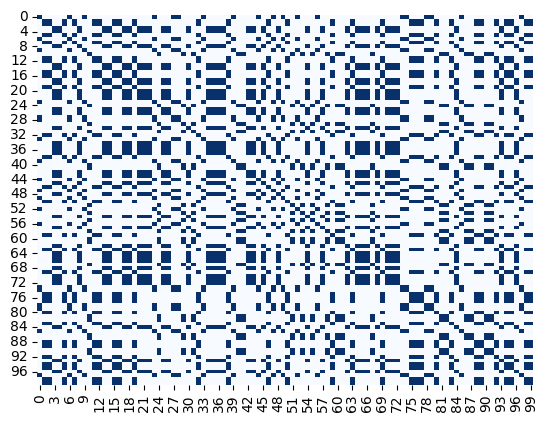

In [34]:
#improved alignment presentation 

# Plot the similarity matrix as a heatmap
sns.heatmap(new_matrix, cmap="Blues", cbar=False)

# Customize the plot
#plt.title('DNA Sequence Alignment')
#plt.xlabel('Sequence 1')
#plt.ylabel('Sequence 2')

# Show the plot
plt.show()